In [76]:
import sys 
sys.path.insert(0, '../')
import time
import torch.optim as optim
import os
import matplotlib.pyplot as plt  # Import the matplotlib library



In [77]:
from common.common import create_folder
from common.pytorch import load_model
import pytorch_pretrained_bert as Bert
from model.utils import age_vocab
from common.common import load_obj
from dataLoader.MLM import MLMLoader
from torch.utils.data import DataLoader
import pandas as pd
from model.MLM import BertForMaskedLM
from model.optimiser import adam
import sklearn.metrics as skm
import numpy as np
import torch
import time
import torch.nn as nn
import os
import pyarrow
import json
import pickle

In [78]:
merged_age_diagnosis = pd.read_csv("/data/datasets/leyang.sun/merged_age_diagnosis.csv")


file_path = "/data/datasets/leyang.sun/merged_age_diagnosis.csv"


original_data = pd.read_csv(file_path)
original_data['age_vector'] = original_data['age_vector'].apply(lambda x: ''.join([char for char in str(x) if (char != ' ' and char != '[' and char != ']')]).split(','))
original_data['age_vector'] = original_data['age_vector'].apply(lambda x: list(map(int, x)))

# Display the result for the first row

# print(original_data['age_vector'][0])



# Assuming 'diagnosis_code' is a column in your DataFrame
original_data['diagnosis_code'] = original_data['diagnosis_code'].apply(lambda x: ''.join([char for char in str(x) if (char != ' ' and char != '[' and char != ']')]).split(','))
# print(original_data['diagnosis_code'][0])



original_data = original_data.rename(columns={'age_vector': 'age'})

parquet_file_path = '/home/leyang.sun/BERHT/BEHRT/saved_data.parquet'  
original_data.to_parquet(parquet_file_path, index=False)

In [79]:
diagnosis_tokens = [code for visit in original_data['diagnosis_code'] for code in visit if code != 'SEP']

# Create a set of unique diagnosis tokens
unique_diagnosis_tokens = set(diagnosis_tokens)

# Create token-to-index and index-to-token mappings
token2idx = {token: idx for idx, token in enumerate(unique_diagnosis_tokens)}
idx2token = {idx: token for token, idx in token2idx.items()}

# Add the 'UNK' token (unknown token) with a unique index
unk_token = 'UNK'
unk_index = len(token2idx)
token2idx[unk_token] = unk_index
idx2token[unk_index] = unk_token

special_tokens = ['CLS', 'SEP','MASK', 'PAD']

# Create token-to-index and index-to-token mappings for special tokens
special_token2idx = {token: idx for idx, token in enumerate(special_tokens)}
special_idx2token = {idx: token for token, idx in special_token2idx.items()}

# Merge 'special_token2idx' into 'token2idx'
token2idx.update(special_token2idx)

# Merge 'special_idx2token' into 'idx2token'
idx2token.update(special_idx2token)

vocab = {
    'token2idx': token2idx,
    'idx2token': idx2token
}

# Save the vocabulary to a Pickle file
vocab_file_path = '/home/leyang.sun/BERHT/BEHRT/saved_vocab.pkl'
with open(vocab_file_path, 'wb') as vocab_file:  # Use 'wb' for binary write mode
    pickle.dump(vocab, vocab_file)

In [80]:
class BertConfig(Bert.modeling.BertConfig):
    def __init__(self, config):
        super(BertConfig, self).__init__(
            vocab_size_or_config_json_file=config.get('vocab_size'),
            hidden_size=config['hidden_size'],
            num_hidden_layers=config.get('num_hidden_layers'),
            num_attention_heads=config.get('num_attention_heads'),
            intermediate_size=config.get('intermediate_size'),
            hidden_act=config.get('hidden_act'),
            hidden_dropout_prob=config.get('hidden_dropout_prob'),
            attention_probs_dropout_prob=config.get('attention_probs_dropout_prob'),
            max_position_embeddings = config.get('max_position_embedding'),
            initializer_range=config.get('initializer_range'),
        )
        self.seg_vocab_size = config.get('seg_vocab_size')
        self.age_vocab_size = config.get('age_vocab_size')
        
class TrainConfig(object):
    def __init__(self, config):
        self.batch_size = config.get('batch_size')
        self.use_cuda = config.get('use_cuda')
        self.max_len_seq = config.get('max_len_seq')
        self.train_loader_workers = config.get('train_loader_workers')
        self.test_loader_workers = config.get('test_loader_workers')
        self.device = config.get('device')
        self.output_dir = config.get('output_dir')
        self.output_name = config.get('output_name')
        self.best_name = config.get('best_name')

In [81]:

file_config = {
    'vocab':'/home/leyang.sun/BERHT/BEHRT/saved_vocab',  # vocabulary idx2token, token2idx
    'data': '/home/leyang.sun/BERHT/BEHRT/saved_data.parquet',  # formated data 
    'model_path': '/home/leyang.sun/BERHT/BEHRT/saved_model', # where to save model
    'model_name': 'BERT_Large_v1_2023-10-19', # model name
    'file_name': 'training_log_2023-10-19.txt',  # log path
}
create_folder(file_config['model_path'])


In [101]:
global_params = {
    'max_seq_len': 64,
    'max_age': 110,
    'month': 1,
    'age_symbol': None,
    'min_visit': 5,
    'gradient_accumulation_steps': 1
}

optim_param = {
    'lr': 3e-5,
    'warmup_proportion': 0.1,
    'weight_decay': 0.01
}

train_params = {
    'batch_size': 256,
    'use_cuda': True,
    'max_len_seq': global_params['max_seq_len'],
    'device': 'cuda:0'
}

In [103]:
BertVocab = load_obj(file_config['vocab'])
ageVocab, _ = age_vocab(max_age=global_params['max_age'], mon=global_params['month'], symbol=global_params['age_symbol'])

In [115]:
data = pd.read_parquet(file_config['data'])


# remove patients with visits less than min visit
# Assuming 'age' is the column containing lists
data['length'] = data['age'].apply(len)

data = data[data['length'] >= global_params['min_visit']]
data = data.reset_index(drop=True)

In [116]:
print(data)




      Unnamed: 0             deid_pat_ID  \
0              0      IRB202001139_PAT_1   
1              1     IRB202001139_PAT_10   
2              2  IRB202001139_PAT_10001   
3              3  IRB202001139_PAT_10002   
4              4  IRB202001139_PAT_10009   
...          ...                     ...   
7595        9915   IRB202001139_PAT_9951   
7596        9916   IRB202001139_PAT_9958   
7597        9917   IRB202001139_PAT_9965   
7598        9918   IRB202001139_PAT_9977   
7599        9920   IRB202001139_PAT_9993   

                                                    age  \
0     [31, 31, 31, 31, 31, 31, 32, 33, 33, 33, 33, 3...   
1     [69, 69, 70, 70, 70, 70, 70, 70, 71, 71, 71, 7...   
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3     [19, 19, 20, 20, 21, 21, 21, 22, 22, 22, 22, 2...   
4     [66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 6...   
...                                                 ...   
7595  [57, 57, 59, 59, 60, 60, 60, 60, 60, 63, 63, 6...   

In [117]:
Dset = MLMLoader(data, BertVocab['token2idx'], ageVocab, max_len=train_params['max_len_seq'], code='diagnosis_code')
trainload = DataLoader(dataset=Dset, batch_size=train_params['batch_size'], shuffle=True, num_workers=3)

In [118]:
model_config = {
    'vocab_size': len(BertVocab['token2idx'].keys()), # number of disease + symbols for word embedding
    'hidden_size': 288, # word embedding and seg embedding hidden size
    'seg_vocab_size': 2, # number of vocab for seg embedding
    'age_vocab_size': len(ageVocab.keys()), # number of vocab for age embedding
    'max_position_embedding': train_params['max_len_seq'], # maximum number of tokens
    'hidden_dropout_prob': 0.1, # dropout rate
    'num_hidden_layers': 6, # number of multi-head attention layers required
    'num_attention_heads': 12, # number of attention heads
    'attention_probs_dropout_prob': 0.1, # multi-head attention dropout rate
    'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
}

In [119]:
conf = BertConfig(model_config)
model = BertForMaskedLM(conf)



In [120]:
model = model.to(train_params['device'])
optim = adam(params=list(model.named_parameters()), config=optim_param)

t_total value of -1 results in schedule not being applied


In [121]:
def cal_acc(label, pred):
    logs = nn.LogSoftmax()
    label=label.cpu().numpy()
    ind = np.where(label!=-1)[0]
    truepred = pred.detach().cpu().numpy()
    truepred = truepred[ind]
    truelabel = label[ind]
    truepred = logs(torch.tensor(truepred))
    outs = [np.argmax(pred_x) for pred_x in truepred.numpy()]
    precision = skm.precision_score(truelabel, outs, average='micro')
    return precision

In [122]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)  # Define the optimizer


In [123]:
def train(e, loader):
    tr_loss = 0
    temp_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    cnt= 0
    start = time.time()

    for step, batch in enumerate(loader):
        cnt +=1
        batch = tuple(t.to(train_params['device']) for t in batch)
        age_ids, input_ids, posi_ids, segment_ids, attMask, masked_label = batch
        loss, pred, label = model(input_ids, age_ids, segment_ids, posi_ids,attention_mask=attMask, masked_lm_labels=masked_label)
        if global_params['gradient_accumulation_steps'] >1:
            loss = loss/global_params['gradient_accumulation_steps']
        loss.backward()
        
        temp_loss += loss.item()
        tr_loss += loss.item()
        
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        
        if step % 200==0:
            print("epoch: {}\t| cnt: {}\t|Loss: {}\t| precision: {:.4f}\t| time: {:.2f}".format(e, cnt, temp_loss/2000, cal_acc(label, pred), time.time()-start))
            temp_loss = 0
            start = time.time()
            
        if (step + 1) % global_params['gradient_accumulation_steps'] == 0:
            optim.step()
            optim.zero_grad()

    print("** ** * Saving fine - tuned model ** ** * ")
    model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
    create_folder(file_config['model_path'])
    output_model_file = os.path.join(file_config['model_path'], file_config['model_name'])

    torch.save(model_to_save.state_dict(), output_model_file)
        
    cost = time.time() - start
    return tr_loss, cost

In [124]:
data_len = len(trainload.dataset)  # Assuming trainload is a DataLoader

f = open(os.path.join(file_config['model_path'], file_config['file_name']), "w")
f.write('{}\t{}\t{}\n'.format('epoch', 'loss', 'time'))
for e in range(50):
    loss, time_cost = train(e, trainload)
    loss = loss / data_len  # Normalize the loss by the number of data points
    f.write('{}\t{}\t{}\n'.format(e, loss, time_cost))
f.close()

/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 0	| cnt: 1	|Loss: 0.0035916595458984376	| precision: 0.0005	| time: 0.60
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 1	| cnt: 1	|Loss: 0.0024297125339508055	| precision: 0.2366	| time: 0.62
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 2	| cnt: 1	|Loss: 0.0022433223724365233	| precision: 0.2248	| time: 0.60
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 3	| cnt: 1	|Loss: 0.002166205883026123	| precision: 0.2416	| time: 0.64
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 4	| cnt: 1	|Loss: 0.002184095621109009	| precision: 0.2493	| time: 0.61
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 5	| cnt: 1	|Loss: 0.0021159541606903076	| precision: 0.2412	| time: 0.62
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 6	| cnt: 1	|Loss: 0.00207871413230896	| precision: 0.2304	| time: 0.61
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 7	| cnt: 1	|Loss: 0.0019889192581176757	| precision: 0.2479	| time: 0.62
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 8	| cnt: 1	|Loss: 0.0019944530725479128	| precision: 0.2581	| time: 0.65
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 9	| cnt: 1	|Loss: 0.002024224281311035	| precision: 0.2271	| time: 0.63
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 10	| cnt: 1	|Loss: 0.0019508943557739258	| precision: 0.2500	| time: 0.62
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 11	| cnt: 1	|Loss: 0.0019545384645462036	| precision: 0.2444	| time: 0.60
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 12	| cnt: 1	|Loss: 0.0019310241937637329	| precision: 0.2441	| time: 0.62
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 13	| cnt: 1	|Loss: 0.0018718374967575074	| precision: 0.2710	| time: 0.61
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 14	| cnt: 1	|Loss: 0.0019214261770248414	| precision: 0.2472	| time: 0.64
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 15	| cnt: 1	|Loss: 0.0018508341312408448	| precision: 0.2509	| time: 0.60
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 16	| cnt: 1	|Loss: 0.001918436646461487	| precision: 0.2405	| time: 0.58
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 17	| cnt: 1	|Loss: 0.0018454086780548096	| precision: 0.2476	| time: 0.65
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 18	| cnt: 1	|Loss: 0.0018539628982543945	| precision: 0.2406	| time: 0.62
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 19	| cnt: 1	|Loss: 0.0018516237735748291	| precision: 0.2411	| time: 0.67
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 20	| cnt: 1	|Loss: 0.0018391141891479492	| precision: 0.2473	| time: 0.70
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 21	| cnt: 1	|Loss: 0.0018296375274658202	| precision: 0.2352	| time: 0.68
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 22	| cnt: 1	|Loss: 0.0018157873153686523	| precision: 0.2441	| time: 0.70
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 23	| cnt: 1	|Loss: 0.0017959338426589966	| precision: 0.2627	| time: 0.71
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 24	| cnt: 1	|Loss: 0.0017881890535354614	| precision: 0.2566	| time: 0.67
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 25	| cnt: 1	|Loss: 0.0017202112674713135	| precision: 0.2769	| time: 0.69
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 26	| cnt: 1	|Loss: 0.0017609912157058715	| precision: 0.2697	| time: 0.66
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 27	| cnt: 1	|Loss: 0.0018743964433670043	| precision: 0.2383	| time: 0.64
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 28	| cnt: 1	|Loss: 0.0017221221923828126	| precision: 0.2714	| time: 0.61
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 29	| cnt: 1	|Loss: 0.0017715866565704346	| precision: 0.2623	| time: 0.60
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 30	| cnt: 1	|Loss: 0.0016802589893341064	| precision: 0.2779	| time: 0.63
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 31	| cnt: 1	|Loss: 0.0017602229118347168	| precision: 0.2488	| time: 0.65
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 32	| cnt: 1	|Loss: 0.0017798879146575927	| precision: 0.2535	| time: 0.62
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 33	| cnt: 1	|Loss: 0.0017395461797714232	| precision: 0.2582	| time: 0.60
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 34	| cnt: 1	|Loss: 0.001730899453163147	| precision: 0.2483	| time: 0.61
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 35	| cnt: 1	|Loss: 0.0017394136190414429	| precision: 0.2541	| time: 0.62
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 36	| cnt: 1	|Loss: 0.0017332818508148193	| precision: 0.2588	| time: 0.62
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 37	| cnt: 1	|Loss: 0.0016562702655792236	| precision: 0.2516	| time: 0.60
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 38	| cnt: 1	|Loss: 0.001688659429550171	| precision: 0.2735	| time: 0.63
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 39	| cnt: 1	|Loss: 0.0016729165315628053	| precision: 0.2607	| time: 0.64
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 40	| cnt: 1	|Loss: 0.0016585628986358642	| precision: 0.2658	| time: 0.61
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 41	| cnt: 1	|Loss: 0.0017157111167907715	| precision: 0.2633	| time: 0.60
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 42	| cnt: 1	|Loss: 0.0017125005722045897	| precision: 0.2541	| time: 0.61
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 43	| cnt: 1	|Loss: 0.001630483865737915	| precision: 0.2743	| time: 0.60
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 44	| cnt: 1	|Loss: 0.0016633245944976806	| precision: 0.2678	| time: 0.61
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 45	| cnt: 1	|Loss: 0.0017243402004241944	| precision: 0.2603	| time: 0.63
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 46	| cnt: 1	|Loss: 0.0016703892946243286	| precision: 0.2452	| time: 0.62
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 47	| cnt: 1	|Loss: 0.0017135223150253295	| precision: 0.2482	| time: 0.60
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 48	| cnt: 1	|Loss: 0.001624280095100403	| precision: 0.2838	| time: 0.62
** ** * Saving fine - tuned model ** ** * 


/tmp/ipykernel_2946/589800408.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  truepred = logs(torch.tensor(truepred))


epoch: 49	| cnt: 1	|Loss: 0.0016519932746887208	| precision: 0.2778	| time: 0.62
** ** * Saving fine - tuned model ** ** * 


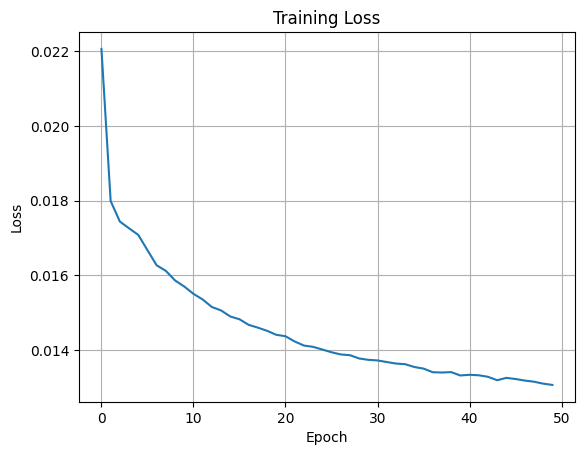

In [125]:


# File path to your text file
file_path = "/home/leyang.sun/BERHT/BEHRT/saved_model/training_log_2023-10-19.txt"

# Lists to store data
epochs = []
losses = []

# Read data from the text file
with open(file_path, "r") as file:
    next(file)  # Skip the header line
    for line in file:
        data = line.split("\t")
        epoch = int(data[0])
        loss = float(data[1])
        epochs.append(epoch)
        losses.append(loss)

# Create a plot
plt.figure()
plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)

# Display the plot or save it to a file
plt.show()  # To display the plot
# To save the plot to a file, use plt.savefig("loss_plot.png")
